# First test
Updated conda environment, updated versions of openMM and openFF, newest openFF forcefield

In [1]:
import sys
sys.path.append('../..')
from carl import utils_carl
from carl.utils_carl import get_mdfps, print_package_versions
print_package_versions()

ff_name: openff_unconstrained-2.1.0.offxml
ff_version:  0.14.3
simulation_type: tMD water solution
md_engine: openMM
version:  8.0
steps_time: 5.0
rdkit version:  2023.03.3


md_experiment_uuids:
1. fc57851e-b654-4338-bcdd-faa28ec66253
2. 7a5837f2-e4ad-4e17-a2c3-6e5e956f938b
note that there are two uuis, one for the initial batch and one to fix some errors that resulted in crashes in the simulation. But in principal, these two are the same. 

- mdfp_experiment_uuid: fc57851e-b654-4338-bcdd-faa28ec66253
- confgen_uuid: 11093a30-b6d0-4e3f-a22b-8dcad60d6a11


In [2]:
import pandas as pd
df_mdfps = get_mdfps(which='one_5ns')
df_experimental = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/experimental_data_cleaning/VP_data_no_duplicates.tsv', sep='\t')
print(len(df_experimental),' datapoints in experimental data')
print(len(df_experimental)-len(df_mdfps),' datapoints missing')

2980 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']
3042  datapoints in experimental data
62  datapoints missing


In [3]:
df_mdfps.sort_values(by='molregno', inplace=True)
df_mdfps

,confid,molregno,mdfp,vp_log10pa
1165,2298,1,"[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.4462820500696...",4.100855
106,1228,6,"[30, 19, 0, 6, 0, 0, 0, 0, 0, 0, 110.748466359...",-11.744727
29,1150,7,"[9, 5, 0, 0, 0, 0, 0, 0, 0, 0, 7.3614322526332...",2.698933
30,1151,8,"[13, 1, 0, 2, 0, 0, 0, 0, 0, 0, -97.7987770071...",-3.053323
31,1152,9,"[5, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0.4848459757350...",3.591625
...,...,...,...,...
2974,4238,4240,"[18, 2, 0, 1, 0, 0, 0, 0, 5, 0, -20.9569257949...",-4.301899
2975,4239,4241,"[17, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0.034004099168...",-5.356584
2976,4240,4242,"[19, 2, 0, 1, 0, 0, 0, 6, 0, 0, -30.8042543707...",-3.770000
2966,4241,4243,"[5, 0, 0, 0, 3, 0, 0, 1, 0, 0, -0.004587864253...",6.457729


At this point, there are some datapoints missing due to errors in the simulations. These will be discussed in Experiments_error_analysis/001_simu

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localho

RMSE:  1.3941944309123953
MAE:  0.8616595552140723
R2:  0.8513712495871104


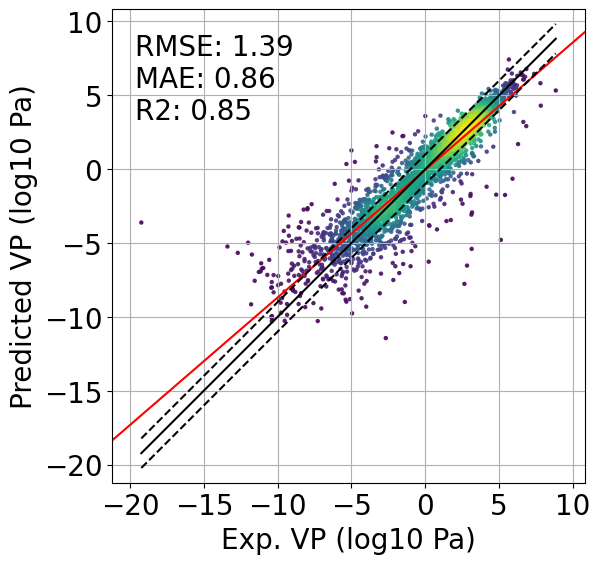

In [8]:
from carl.utils_carl import train_pred_xgboost, getStatValues,density_plot
from functools import reduce
params = {
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
vps, preds, mrns, confids = train_pred_xgboost(df_mdfps,params,splits=5)
# vps, preds, mrns, confids= (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
density_plot(vps,preds)
